In [139]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

The dataset to be used in this project is a modified version of the dataset create by Paul Clough and Mark Stevenson. The complete description of the data generation process is described in their [research article](https://link.springer.com/article/10.1007/s10579-009-9112-1) (Clough, P., Stevenson, M. Developing a corpus of plagiarised short answers, 2011)

### Description of the dataset

<li> The dataset contains several txt files whose characteristics are summarized in the file_information.csv file. </li>
<li> The dataset has 100 files, out of which 5 are the original answers. Therefore, the participants contributed with 95 anwers, divided in 5 tasks and 5 plagiarism methods. </li>
<li> The <b>File</b> column in the file_information.csv file contains the name of the txt file. </li>
<li> The <b>Task</b> column contains one of the five learning task (A-E) that each txt answers. </li>
<li> The <b>Category</b> column indicates if the participant was asked to use a Near copy (cut), Light revision (light), Heavy revision (heavy) or Non-plagiarised (non) method to answer the question. This column also contains the 'orig' category to reference the original texts on which participants based their answers</li>

In [140]:
data_dir = Path(r"C:\Users\snehi\Documents\CTDS\Plagiarism Detection\data")

#load metadata
summary_data = pd.read_csv(data_dir / "file_information.csv")
summary_data.head()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


In [141]:
#this is very useful later for evaluating how well the similarity or clustering methods separate plagiarised vs non

#mapping 5-category label to numeric id
category_to_id = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}
summary_data['category_id'] = summary_data['Category'].map(category_to_id)

#binary plagiarism label: 1 = plagiarised (cut / light / heavy), 0 = non, -1 = original
def to_plag_label(cat):
    if cat == 'non':
        return 0
    if cat == 'orig':
        return -1
    return 1

summary_data['plag_label'] = summary_data['Category'].apply(to_plag_label)

summary_data.head()


,File,Task,Category,category_id,plag_label
0,g0pA_taska.txt,a,non,0,0
1,g0pA_taskb.txt,b,cut,3,1
2,g0pA_taskc.txt,c,light,2,1
3,g0pA_taskd.txt,d,heavy,1,1
4,g0pA_taske.txt,e,non,0,0


In [142]:
#preprocessing functions

#load raw text and create a cleaned version
def read_file_text(path):
    #read file as raw text for sentence embeddings
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def clean_text(text):
    #basic cleaning for tfidf and hashing - convert text to lowercase, remove punctuation, and tidy the whitespace
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)   #remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  #normalising whitespace
    return text

#raw text keeps punctuation - for sentence embeddings
summary_data["raw_text"] = summary_data["File"].apply(lambda fn: read_file_text(data_dir / fn))

#clean text - for tfidf and hashing
summary_data["clean_text"] = summary_data["raw_text"].apply(clean_text)

#save to csv
summary_data.to_csv(data_dir / "preprocessed_dataset.csv", index=False)

summary_data.head()


,File,Task,Category,category_id,plag_label,raw_text,clean_text
0,g0pA_taska.txt,a,non,0,0,Inheritance is a basic concept of Object-Orien...,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,cut,3,1,PageRank is a link analysis algorithm used by ...,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,light,2,1,"The vector space model (also called, term vect...",the vector space model also called term vector...
3,g0pA_taskd.txt,d,heavy,1,1,Bayes’ theorem was names after Rev Thomas Baye...,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,non,0,0,Dynamic Programming is an algorithm design tec...,dynamic programming is an algorithm design tec...


c:\Users\snehi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans (k=5): silhouette=0.342, ARI(task)=1.000, purity(task)=1.000
Confusion matrix (rows=true Task IDs, cols=cluster IDs):
 [[ 0 20  0  0  0]
 [ 0  0  0  0 20]
 [ 0  0 20  0  0]
 [ 0  0  0 20  0]
 [20  0  0  0  0]]

KMeans mapped → Task labels:
  Accuracy : 1.000
  Precision (macro): 1.000
  Recall    (macro): 1.000
  F1-score  (macro): 1.000

Per-class report (Task A–E):
              precision    recall  f1-score   support

           a       1.00      1.00      1.00        20
           b       1.00      1.00      1.00        20
           c       1.00      1.00      1.00        20
           d       1.00      1.00      1.00        20
           e       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



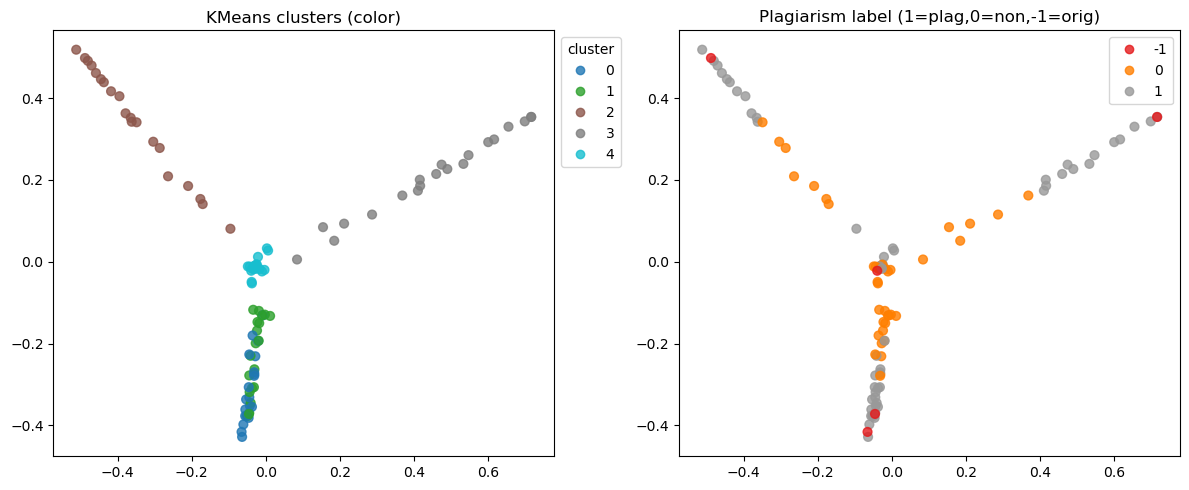

Cluster assignments saved to: C:\Users\snehi\Documents\CTDS\Plagiarism Detection\data\preprocessed_with_clusters_kmeans_only.csv


In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    classification_report,
)
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare features (TF-IDF on clean_text)
texts = summary_data["clean_text"].astype(str).tolist()
tfidf = TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(texts)

# 2. Dimensionality reduction for clustering and visualization
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# 3. KMeans clustering (by Task; 5 tasks A–E)
n_clusters = summary_data["Task"].nunique()  # should be 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_km = kmeans.fit_predict(X_reduced)

# 4. Evaluation helpers
def purity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

# Map Task letters to integer labels for ARI / classification
task_to_id = {t: i for i, t in enumerate(sorted(summary_data["Task"].unique()))}
id_to_task = {v: k for k, v in task_to_id.items()}
task_labels = summary_data["Task"].map(task_to_id).values

# Binary plag labels (if you need them for other things)
plag_labels = summary_data["plag_label"].values

# 5. Unsupervised metrics (cluster quality)
sil_km = silhouette_score(X_reduced, clusters_km, metric="cosine")
ari_km = adjusted_rand_score(task_labels, clusters_km)
purity_km = purity_score(task_labels, clusters_km)

print(f"KMeans (k={n_clusters}): silhouette={sil_km:.3f}, ARI(task)={ari_km:.3f}, purity(task)={purity_km:.3f}")

# 6. Map clusters -> majority Task to compute precision/recall/F1/accuracy
cm = confusion_matrix(task_labels, clusters_km)
print("Confusion matrix (rows=true Task IDs, cols=cluster IDs):\n", cm)

cluster_to_task = {}
for c in range(cm.shape[1]):
    majority_task_id = cm[:, c].argmax()
    cluster_to_task[c] = majority_task_id

# Apply mapping
clusters_km_mapped = np.vectorize(cluster_to_task.get)(clusters_km)

acc = accuracy_score(task_labels, clusters_km_mapped)
prec_macro = precision_score(task_labels, clusters_km_mapped, average="macro", zero_division=0)
recall_macro = recall_score(task_labels, clusters_km_mapped, average="macro", zero_division=0)
f1_macro = f1_score(task_labels, clusters_km_mapped, average="macro", zero_division=0)

print(f"\nKMeans mapped → Task labels:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision (macro): {prec_macro:.3f}")
print(f"  Recall    (macro): {recall_macro:.3f}")
print(f"  F1-score  (macro): {f1_macro:.3f}\n")

print("Per-class report (Task A–E):")
print(
    classification_report(
        task_labels,
        clusters_km_mapped,
        target_names=[id_to_task[i] for i in range(len(id_to_task))],
        zero_division=0,
    )
)

# 7. 2D visualization (PCA on reduced features -> for plotting)
pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_reduced)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# left: KMeans clusters
scatter = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=clusters_km, cmap="tab10", s=40, alpha=0.8)
axes[0].set_title("KMeans clusters (color)")
axes[0].legend(*scatter.legend_elements(), title="cluster", bbox_to_anchor=(1, 1))

# right: plagiarism labels
uniq_pl = np.unique(plag_labels)
colors = {val: i for i, val in enumerate(uniq_pl)}
pl_colors = [colors[v] for v in plag_labels]
scatter2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=pl_colors, cmap="Set1", s=40, alpha=0.8)
axes[1].set_title("Plagiarism label (1=plag,0=non,-1=orig)")
axes[1].legend(handles=scatter2.legend_elements()[0], labels=[str(v) for v in uniq_pl], bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# 8. Save cluster assignments back to dataframe
summary_data["kmeans_cluster"] = clusters_km
summary_data["kmeans_cluster_mapped_to_task"] = clusters_km_mapped

summary_data.to_csv(data_dir / "preprocessed_with_clusters_kmeans_only.csv", index=False)
print("Cluster assignments saved to:", data_dir / "preprocessed_with_clusters_kmeans_only.csv")


There is no way for clustering to detect plagiarism category, because:

- plagiarism does not form natural clusters
- plagiarism is a degree of similarity, not group membership
- each plagiarised document is closer to its own original than to any other document

Increasing the number of clusters in KMeans (for example, from 5 to 10) won’t truly improve plagiarism detection. The algorithm is grouping files based on what task they belong to, because all answers for the same task use similar words and topics. That is why it already separates the five tasks perfectly. If you add more clusters, it will just split each task into smaller pieces, but it will not separate plagiarised and non-plagiarised texts. This is because plagiarism is not a clear group in the data; it is more like a scale from very similar to very different. So, more clusters will not make the plagiarism detection better.

Instead, we use a better method to find how close a file is to its original by using TF-IDF vectors and a cosine similarity matrix, which measure how similar the words and phrases in one text are to those in another.


In [144]:
#A better method to find how close a file is to it's original - use TF-IDF + cosine similarity matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

#Prepare TF-IDF
texts = summary_data["clean_text"].astype(str).tolist()

tfidf = TfidfVectorizer(
    max_df=0.85,
    min_df=2,
    ngram_range=(1,2)
)
X_tfidf = tfidf.fit_transform(texts)

#Compute cosine similarity matrix (100 × 100)
similarity_matrix = cosine_similarity(X_tfidf)

#Put into a DataFrame
sim_df = pd.DataFrame(
    similarity_matrix,
    index=summary_data["File"],
    columns=summary_data["File"]
)

sim_df.head()


File,g0pA_taska.txt,g0pA_taskb.txt,g0pA_taskc.txt,g0pA_taskd.txt,g0pA_taske.txt,g0pB_taska.txt,g0pB_taskb.txt,g0pB_taskc.txt,g0pB_taskd.txt,g0pB_taske.txt,...,g4pE_taska.txt,g4pE_taskb.txt,g4pE_taskc.txt,g4pE_taskd.txt,g4pE_taske.txt,orig_taska.txt,orig_taskb.txt,orig_taskc.txt,orig_taskd.txt,orig_taske.txt
File,,,,,,,,,,,,,,,,,,,,,
g0pA_taska.txt,1.000000,0.021034,0.031065,0.132914,0.022203,0.274732,0.039503,0.039883,0.051209,0.034214,...,0.224382,0.017658,0.036491,0.049415,0.030010,0.162409,0.025321,0.030875,0.027007,0.048857
g0pA_taskb.txt,0.021034,1.000000,0.050553,0.020918,0.025296,0.020119,0.246163,0.043015,0.060795,0.020127,...,0.024081,0.389810,0.051846,0.059309,0.029514,0.041222,0.711116,0.035932,0.049145,0.029954
g0pA_taskc.txt,0.031065,0.050553,1.000000,0.039986,0.023964,0.044194,0.045300,0.741959,0.053029,0.040599,...,0.036099,0.050207,0.506749,0.065895,0.049455,0.046704,0.055956,0.812890,0.052281,0.055152
g0pA_taskd.txt,0.132914,0.020918,0.039986,1.000000,0.032630,0.034032,0.040078,0.036781,0.288881,0.051982,...,0.035862,0.027933,0.023372,0.194799,0.047188,0.041734,0.031636,0.041382,0.416879,0.044520
g0pA_taske.txt,0.022203,0.025296,0.023964,0.032630,1.000000,0.029932,0.022467,0.021595,0.038783,0.247563,...,0.041400,0.020123,0.013185,0.037604,0.253803,0.042595,0.032220,0.022565,0.027762,0.221031


In [145]:
#Find the top 3 most similar file for each document
def top_match(sim_row, this_file, k=3):
    scores = sim_row.drop(this_file)  # remove self-similarity = 1.0
    return scores.sort_values(ascending=False).head(k)

nearest_neighbors = {}

for file in summary_data["File"]:
    nearest_neighbors[file] = top_match(sim_df.loc[file], file, k=3)

nearest_neighbors


{'g0pA_taska.txt': File
 g3pB_taska.txt    0.319345
 g2pB_taska.txt    0.317875
 g1pB_taska.txt    0.293223
 Name: g0pA_taska.txt, dtype: float64,
 'g0pA_taskb.txt': File
 orig_taskb.txt    0.711116
 g0pE_taskb.txt    0.535844
 g1pD_taskb.txt    0.446716
 Name: g0pA_taskb.txt, dtype: float64,
 'g0pA_taskc.txt': File
 orig_taskc.txt    0.812890
 g2pA_taskc.txt    0.766958
 g0pB_taskc.txt    0.741959
 Name: g0pA_taskc.txt, dtype: float64,
 'g0pA_taskd.txt': File
 g2pA_taskd.txt    0.531322
 g0pC_taskd.txt    0.452243
 g2pC_taskd.txt    0.448423
 Name: g0pA_taskd.txt, dtype: float64,
 'g0pA_taske.txt': File
 g2pA_taske.txt    0.561952
 g2pE_taske.txt    0.501278
 g1pD_taske.txt    0.493480
 Name: g0pA_taske.txt, dtype: float64,
 'g0pB_taska.txt': File
 g2pB_taska.txt    0.375273
 g4pE_taska.txt    0.369250
 g2pA_taska.txt    0.320273
 Name: g0pB_taska.txt, dtype: float64,
 'g0pB_taskb.txt': File
 g1pB_taskb.txt    0.411532
 g2pC_taskb.txt    0.390456
 g2pA_taskb.txt    0.348661
 Name: g0p

In [146]:
#matching each file to its original one

orig_files = summary_data.loc[summary_data["plag_label"] == -1, "File"].tolist()
orig_files


['orig_taska.txt',
 'orig_taskb.txt',
 'orig_taskc.txt',
 'orig_taskd.txt',
 'orig_taske.txt']

In [147]:
#which original each file is closest to
def most_similar_original(file, file_idx):
    sims = {}
    for orig in orig_files:
        orig_idx = summary_data.index[summary_data["File"] == orig][0]
        sims[orig] = similarity_matrix[file_idx, orig_idx]
    return max(sims, key=sims.get), sims

file_to_best_orig = {}

for i, file in enumerate(summary_data["File"]):
    best_orig, sims = most_similar_original(file, i)
    file_to_best_orig[file] = (best_orig, sims)

file_to_best_orig


{'g0pA_taska.txt': ('orig_taska.txt',
  {'orig_taska.txt': 0.16240889437534164,
   'orig_taskb.txt': 0.0253211602960383,
   'orig_taskc.txt': 0.03087466205020786,
   'orig_taskd.txt': 0.02700687635517282,
   'orig_taske.txt': 0.04885699880794287}),
 'g0pA_taskb.txt': ('orig_taskb.txt',
  {'orig_taska.txt': 0.04122221995702918,
   'orig_taskb.txt': 0.7111161536088209,
   'orig_taskc.txt': 0.035932305824182074,
   'orig_taskd.txt': 0.049144739551958236,
   'orig_taske.txt': 0.029953822238704346}),
 'g0pA_taskc.txt': ('orig_taskc.txt',
  {'orig_taska.txt': 0.046704066497526446,
   'orig_taskb.txt': 0.0559557809706033,
   'orig_taskc.txt': 0.8128902246706526,
   'orig_taskd.txt': 0.05228058275311871,
   'orig_taske.txt': 0.05515161675194483}),
 'g0pA_taskd.txt': ('orig_taskd.txt',
  {'orig_taska.txt': 0.041734481528904036,
   'orig_taskb.txt': 0.03163580667110497,
   'orig_taskc.txt': 0.04138172326460148,
   'orig_taskd.txt': 0.4168791640429039,
   'orig_taske.txt': 0.04452018047383439}),


In [148]:
#buildiing a full plagiarism classifier, here I'm turning similarity scores into labels
def plagiarism_level(sim):
    if sim > 0.85:
        return "cut / near copy"
    if sim > 0.60:
        return "light plagiarism"
    if sim > 0.35:
        return "heavy plagiarism"
    return "non-plagiarised"

plag_predictions = []

for i, file in enumerate(summary_data["File"]):
    best_orig, sims = file_to_best_orig[file]
    sim_score = sims[best_orig]
    plag_predictions.append(plagiarism_level(sim_score))

summary_data["predicted_plagiarism_level"] = plag_predictions
summary_data[["File", "predicted_plagiarism_level"]].head(10)

#Saving the results into "predicted_plagiarism_level.csv"
summary_data.to_csv(data_dir / "predicted_plagiarism_level.csv", index=False)
print("Cluster assignments saved to:", data_dir / "predicted_plagiarism_level.csv")

Cluster assignments saved to: C:\Users\snehi\Documents\CTDS\Plagiarism Detection\data\predicted_plagiarism_level.csv


In [149]:
# Ground truth category mapping
true_map = {
    "cut": "cut / near copy",
    "light": "light plagiarism",
    "heavy": "heavy plagiarism",
    "non": "non-plagiarised",
    "orig": "non-plagiarised"   #originals are not plagiarised
}

summary_data["true_plagiarism_level"] = summary_data["Category"].map(true_map)

comparison = summary_data[[
    "File",
    "Task",
    "Category",
    "true_plagiarism_level",
    "predicted_plagiarism_level"
]]

comparison.head(20)

#computing overall accuracy
accuracy = np.mean(
    summary_data["true_plagiarism_level"] == summary_data["predicted_plagiarism_level"]
)

print("Plagiarism-level accuracy:", accuracy)


Plagiarism-level accuracy: 0.6


In [150]:
from sklearn.metrics import confusion_matrix

labels = [
    "non-plagiarised",
    "cut / near copy",
    "light plagiarism",
    "heavy plagiarism"
]

#comparing the true labels to the predicted ones
cm = confusion_matrix(
    summary_data["true_plagiarism_level"],
    summary_data["predicted_plagiarism_level"],
    labels=labels
)

print("Labels:", labels)
print("Confusion matrix:\n", cm)


Labels: ['non-plagiarised', 'cut / near copy', 'light plagiarism', 'heavy plagiarism']
Confusion matrix:
 [[36  5  0  2]
 [ 2  4  6  7]
 [ 0  2  7 10]
 [ 2  1  3 13]]


In [151]:
mismatches = comparison[
    comparison["true_plagiarism_level"] != comparison["predicted_plagiarism_level"]
]

print("\nMISMATCHES:")
display(mismatches)



MISMATCHES:


,File,Task,Category,true_plagiarism_level,predicted_plagiarism_level
1,g0pA_taskb.txt,b,cut,cut / near copy,light plagiarism
13,g0pC_taskd.txt,d,cut,cut / near copy,light plagiarism
14,g0pC_taske.txt,e,light,light plagiarism,heavy plagiarism
15,g0pD_taska.txt,a,cut,cut / near copy,light plagiarism
16,g0pD_taskb.txt,b,light,light plagiarism,heavy plagiarism
17,g0pD_taskc.txt,c,heavy,heavy plagiarism,light plagiarism
20,g0pE_taska.txt,a,light,light plagiarism,cut / near copy
24,g0pE_taske.txt,e,cut,cut / near copy,heavy plagiarism
27,g1pA_taskc.txt,c,light,light plagiarism,heavy plagiarism
28,g1pA_taskd.txt,d,cut,cut / near copy,heavy plagiarism


In [152]:
#an attempt to tune the thresholds for better accuracy
import numpy as np

def predict_with_thresholds(sim, t_cut, t_light, t_heavy):
    if sim > t_cut: return "cut / near copy"
    if sim > t_light: return "light plagiarism"
    if sim > t_heavy: return "heavy plagiarism"
    return "non-plagiarised"

#recompute similarity to best original for each file
best_sims = []
for file in summary_data["File"]:
    best_orig, sims = file_to_best_orig[file]
    best_sims.append(sims[best_orig])
summary_data["best_sim_to_orig"] = best_sims

best_acc = 0
best_params = None

for t_cut in np.arange(0.75, 0.95, 0.02):
  for t_light in np.arange(0.55, t_cut, 0.02):
    for t_heavy in np.arange(0.25, t_light, 0.02):
        preds = [
            predict_with_thresholds(s, t_cut, t_light, t_heavy)
            for s in summary_data["best_sim_to_orig"]
        ]
        acc = np.mean(np.array(preds) == summary_data["true_plagiarism_level"].values)
        if acc > best_acc:
            best_acc = acc
            best_params = (t_cut, t_light, t_heavy)

print("Best accuracy:", best_acc, "with thresholds:", best_params)


Best accuracy: 0.63 with thresholds: (0.8500000000000001, 0.6300000000000001, 0.3700000000000001)


In [155]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# unpack best thresholds
t_cut, t_light, t_heavy = best_params
print("Using thresholds:", best_params)

#Get predictions with the tuned thresholds
preds_tuned = [
    predict_with_thresholds(s, t_cut, t_light, t_heavy)
    for s in summary_data["best_sim_to_orig"]
]

summary_data["predicted_plagiarism_level_tuned"] = preds_tuned

#metrics
y_true = summary_data["true_plagiarism_level"]

acc = accuracy_score(y_true, preds_tuned)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, preds_tuned, average="macro", zero_division=0
)

print(f"Accuracy (tuned): {acc:.3f}")
print(f"Precision (macro, tuned): {prec_macro:.3f}")
print(f"Recall    (macro, tuned): {rec_macro:.3f}")
print(f"F1-score  (macro, tuned): {f1_macro:.3f}")
print("\nClassification report (tuned thresholds):")
print(classification_report(y_true, preds_tuned, zero_division=0))


Using thresholds: (0.8500000000000001, 0.6300000000000001, 0.3700000000000001)
Accuracy (tuned): 0.630
Precision (macro, tuned): 0.552
Recall    (macro, tuned): 0.557
F1-score  (macro, tuned): 0.536

Classification report (tuned thresholds):
                  precision    recall  f1-score   support

 cut / near copy       0.33      0.21      0.26        19
heavy plagiarism       0.45      0.79      0.58        19
light plagiarism       0.54      0.37      0.44        19
 non-plagiarised       0.88      0.86      0.87        43

        accuracy                           0.63       100
       macro avg       0.55      0.56      0.54       100
    weighted avg       0.63      0.63      0.62       100

